In [45]:
import cv2 as cv
import matplotlib.pyplot as plt

In [4]:
from Datasets import Datasets

ac_dataset = Datasets.datasets()["AcMüDüHo"]

train_images = ac_dataset[0].images
train_labels = ac_dataset[0].labels

test_images = ac_dataset[1].images
test_labels = ac_dataset[1].labels

validation_images = ac_dataset[2].images
validation_labels = ac_dataset[2].labels

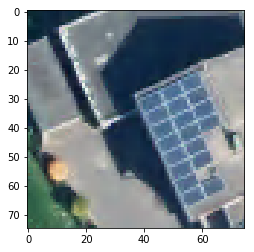

In [38]:
%matplotlib inline

import numpy as np

positives = train_images[train_labels == 1]

image = abs(positives[0]) * 255
plt.imshow(image[:,:,::-1].astype(int))


In [41]:
# images are stored as BGR, to plot we need to invert the channels
def plot_image(image):
    corrected_image = abs(image) * 255
    plt.imshow(corrected_image[:,:,::-1].astype(int))

In [73]:
def plot_image_ax(ax, image):
    corrected_image = abs(image) * 255
    ax.imshow(corrected_image[:,:,::-1].astype(int))

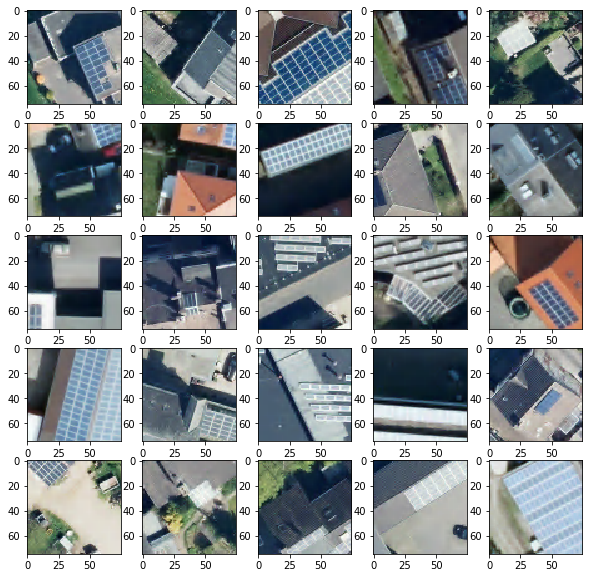

In [172]:
def plot_grid(images, grid_size=(3,3), figsize=(10,10)):
    num_rows, num_cols = grid_size
    _, ax = plt.subplots(num_rows, num_cols, figsize=figsize)
    i = 0
    for r in range(num_rows):
        for c in range(num_cols):
            if i >= len(images):
                continue
            plot_image_ax(ax[r,c], images[i])
            i += 1

plot_grid(positives, (5,5))

In [77]:
positives[0].shape

(75, 75, 3)

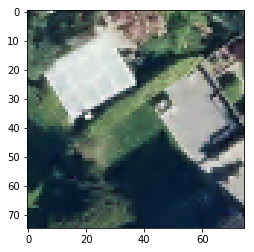

In [44]:
plot_image(positives[4])

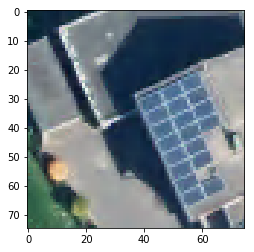

In [50]:
plot_image(positives[0])

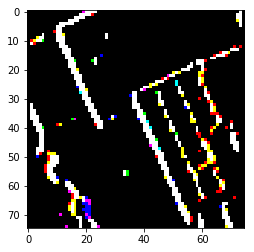

In [155]:
grad_x = cv.Sobel(positives[0], cv.CV_8U, 1, 0)
plot_image(grad_x)

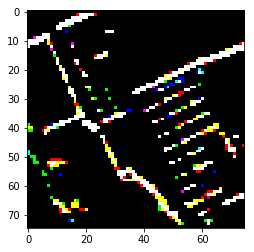

In [62]:
grad_y = cv.Sobel(positives[0], cv.CV_8U, 0, 1)
plot_image(grad_y)

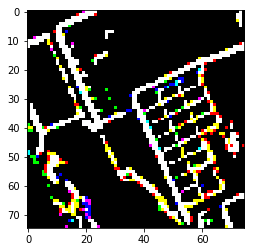

In [58]:
grad = grad_x + grad_y
plot_image(grad)

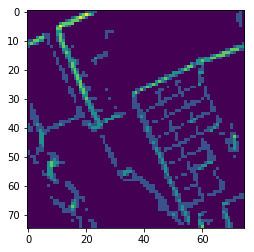

In [67]:
grad_gray = cv2.cvtColor(grad, cv.COLOR_BGR2GRAY)
plt.imshow(grad_gray)

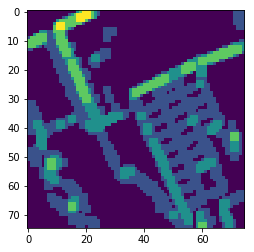

In [145]:
element = cv.getStructuringElement(cv.MORPH_RECT, (3, 3))
grad_dil = cv.dilate(grad_gray, element)
plt.imshow(grad_dil)

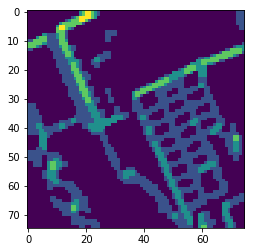

In [146]:
element = cv.getStructuringElement(cv.MORPH_RECT, (2, 2))
grad_er = cv.erode(grad_dil, element)
plt.imshow(grad_er)

In [79]:
positives[0].shape

(75, 75, 3)

In [150]:
cnts = cv2.findContours(grad_er, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


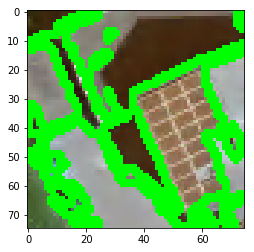

In [151]:
img = positives[0].copy()
cv2.drawContours(img, cnts[1], -1, (0, 255, 0), 2)
plt.imshow(img)

# Fourier transform

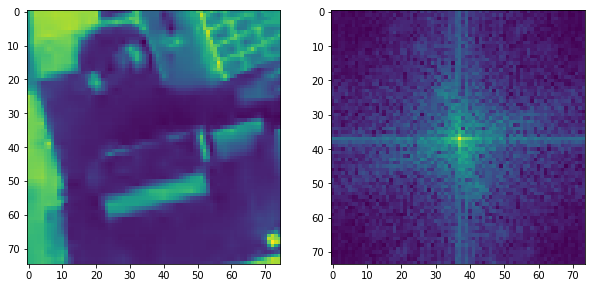

In [168]:
I = cv2.cvtColor(positives[5].astype(np.float32), cv.COLOR_BGR2GRAY)

rows, cols = I.shape
m = cv.getOptimalDFTSize( rows )
n = cv.getOptimalDFTSize( cols )
padded = cv.copyMakeBorder(I, 0, m - rows, 0, n - cols, cv.BORDER_CONSTANT, value=[0, 0, 0])

planes = [np.float32(padded), np.zeros(padded.shape, np.float32)]
complexI = cv.merge(planes)         # Add to the expanded another plane with zeros

cv.dft(complexI, complexI)         # this way the result may fit in the source matrix

cv.split(complexI, planes)                   # planes[0] = Re(DFT(I), planes[1] = Im(DFT(I))
cv.magnitude(planes[0], planes[1], planes[0])# planes[0] = magnitude
magI = planes[0]

matOfOnes = np.ones(magI.shape, dtype=magI.dtype)
cv.add(matOfOnes, magI, magI) #  switch to logarithmic scale
cv.log(magI, magI)

magI_rows, magI_cols = magI.shape
# crop the spectrum, if it has an odd number of rows or columns
magI = magI[0:(magI_rows & -2), 0:(magI_cols & -2)]
cx = int(magI_rows/2)
cy = int(magI_cols/2)
q0 = magI[0:cx, 0:cy]         # Top-Left - Create a ROI per quadrant
q1 = magI[cx:cx+cx, 0:cy]     # Top-Right
q2 = magI[0:cx, cy:cy+cy]     # Bottom-Left
q3 = magI[cx:cx+cx, cy:cy+cy] # Bottom-Right
tmp = np.copy(q0)               # swap quadrants (Top-Left with Bottom-Right)
magI[0:cx, 0:cy] = q3
magI[cx:cx + cx, cy:cy + cy] = tmp
tmp = np.copy(q1)               # swap quadrant (Top-Right with Bottom-Left)
magI[cx:cx + cx, 0:cy] = q2
magI[0:cx, cy:cy + cy] = tmp

cv.normalize(magI, magI, 0, 1, cv.NORM_MINMAX) # Transform the matrix with float values into a

_, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(I)
ax[1].imshow(magI)